In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
data = pd.read_csv("fr_openfoodfacts_org_products.csv", lineterminator='\n', delimiter='\t', on_bad_lines='skip', low_memory=False)

In [59]:
data.shape

(320749, 162)

# *Nettoyage*
  
  **1**. Elémination des colonnes vides à partir d'un certain seuil 

In [60]:
def search_componant(df, suffix='_100g'):
  componant = []
  for col in df.columns:
      if suffix in col: componant.append(col)
  df_subset_columns = df[componant]
  return df_subset_columns

In [61]:
subset_features = search_componant(data, suffix='_100g')
subset_features.shape

(320749, 99)

In [62]:
def null_factor(df, tx_threshold=50):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [63]:
full_null_rate = null_factor(subset_features, 100)
full_null_rate

,Variable,Taux_de_Null
0,water-hardness_100g,100.0
1,behenic-acid_100g,100.0
2,elaidic-acid_100g,100.0
3,gondoic-acid_100g,100.0
4,mead-acid_100g,100.0
5,erucic-acid_100g,100.0
6,melissic-acid_100g,100.0
7,cerotic-acid_100g,100.0
8,lignoceric-acid_100g,100.0
9,dihomo-gamma-linolenic-acid_100g,100.0


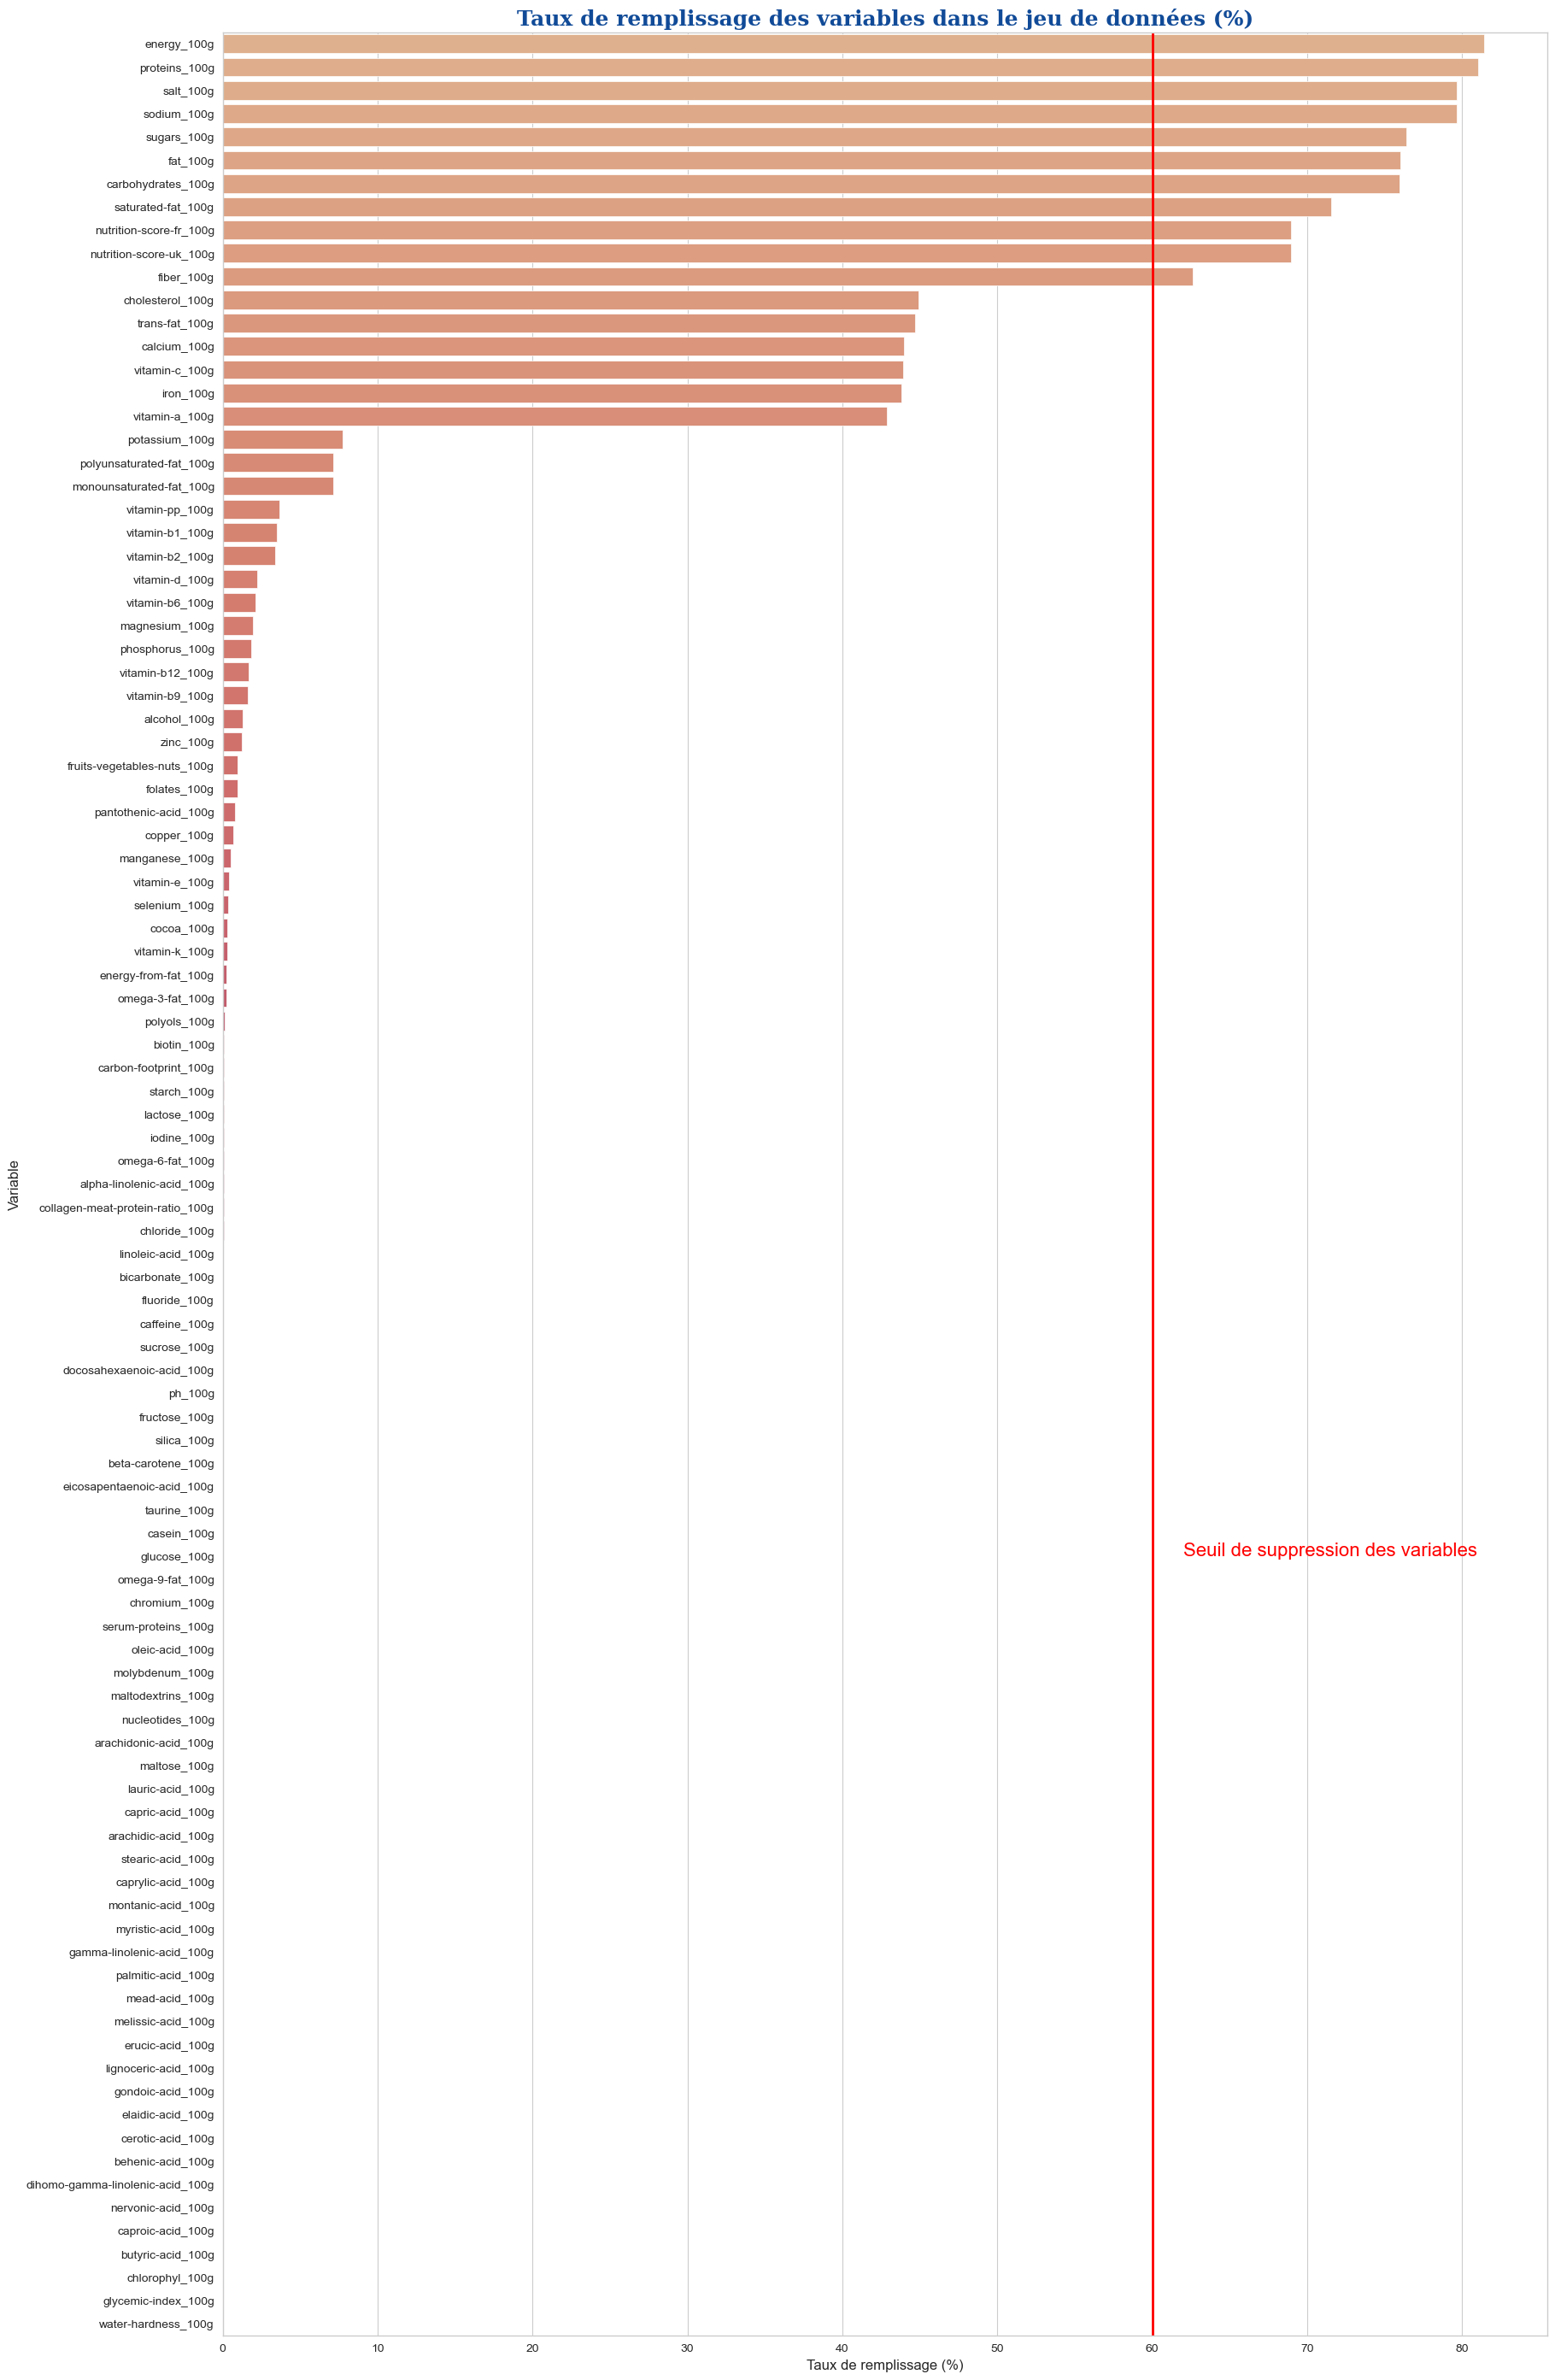

In [64]:
filling_features = null_factor(subset_features, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 60

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.savefig("Taux_de_remplissage.png")
plt.show()


Suppression des variables peu renseignées : 

In [10]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
subset_features = subset_features[features_to_conserve]
subset_features.shape

(320749, 11)

In [11]:
subset_features.columns

Index(['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'fiber_100g'],
      dtype='object')

In [12]:
# util_col : liste des colonnes contenant des informations utiles
util_col = ['code', 'product_name', 'categories_fr','main_category_fr', 'pnns_groups_1','pnns_groups_2']

# feature_col : liste des colonnes correspondants aux features
feature_col = list(subset_features.columns)

# selected_feature_col : liste des colonnes correspondants aux features ayant a priori un lien avec notre application
selected_feature_col = ['sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fiber_100g']

# target_col : notre colonne cible (de notre application) 
target_col = ['glycemic-index_100g']

# Tableau data avec les colonnes citées ci-dessus 
data = data.loc[:, util_col + feature_col + target_col ]
data.shape

(320749, 18)

In [13]:
data.sample()

,code,product_name,categories_fr,main_category_fr,pnns_groups_1,pnns_groups_2,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g,glycemic-index_100g
248372,3660088138155,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Suppression des doublons en fonction du code
data.drop_duplicates(subset ="code", keep = 'last', inplace=True)
data.shape

(320749, 18)

In [15]:
# Suppression des lignes vides
data = data.dropna(axis=0, how='all')
data.shape

(320749, 18)

In [16]:
# Suppression des lignes dont TOUTES les colonnes "utiles" sont vides
data_cleaned = data[~((data.product_name.isnull()) &(data.categories_fr.isnull()) &
                 (data.main_category_fr.isnull()) & (data.pnns_groups_1.isnull()) & (data.pnns_groups_2.isnull()))]
data_cleaned.shape

(306155, 18)

In [17]:
# Suppression des lignes dont toutes les "features" sont à 0 ou nulles
data_cleaned = data_cleaned.loc[~(  (data_cleaned[feature_col]==0) | (data_cleaned[feature_col].isnull()) ).all(axis=1)]
data_cleaned.shape

(256353, 18)

In [18]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
#data_cleaned = data_cleaned[~(data_cleaned[feat_col] < 0).any(axis=1)]
#data_cleaned = data_cleaned[~(data_cleaned[feat_col].isin([999999,9999999])).any(axis=1)]
#data_cleaned.shape

In [19]:
#data_cleaned2 = data_cleaned[~(data_cleaned[feat_col] > 100).any(axis=1)]
#data_cleaned2.shape

In [20]:
#feature_col[1:8] + feature_col[10:]


In [21]:
# On remplace les valeurs négatives ou supérieures à 100 par NAN
#for col in feature_col[1:8] + feature_col[10:]:
for col in feature_col: 
    data_cleaned.loc[:,col] = data_cleaned.loc[:,col].apply(lambda x: np.nan if (x<0 or x>100) else x)

In [22]:
data_cleaned[feature_col].head(5)

,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g
1,NaN,3.57,0.00000,0.000,14.29,28.57,64.29,28.57,14.0,14.0,3.6
2,NaN,17.86,0.63500,0.250,17.86,17.86,60.71,0.00,0.0,0.0,7.1
3,NaN,17.86,1.22428,0.482,3.57,57.14,17.86,5.36,12.0,12.0,7.1
4,NaN,8.57,NaN,NaN,NaN,1.43,77.14,NaN,NaN,NaN,5.7
5,NaN,13.46,NaN,NaN,11.54,18.27,63.46,1.92,NaN,NaN,7.7


In [23]:
data_cleaned.shape

(256353, 18)

**2.** Suppression des valeurs atypiques et aberrantes : 

In [24]:
data_cleaned = data_cleaned[~((data_cleaned['saturated-fat_100g'] > data_cleaned['fat_100g']) 
                                | (data_cleaned['sugars_100g'] > data_cleaned['carbohydrates_100g'])
                                | (data_cleaned['fiber_100g'] > data_cleaned['carbohydrates_100g']))]
data_cleaned.shape

(252826, 18)

In [25]:
# RENOMMER DES FEATURES

#data_cleaned=data_cleaned.rename(columns=({'fat_100g' : 'MG_100g',  'saturated-fat_100g' : 'MGS_100g', 'carbohydrates_100g' : 'glucides_100g'}))
#feat_col = list(data_cleaned.columns[6:-1])
#data_cleaned[feat_col].head()

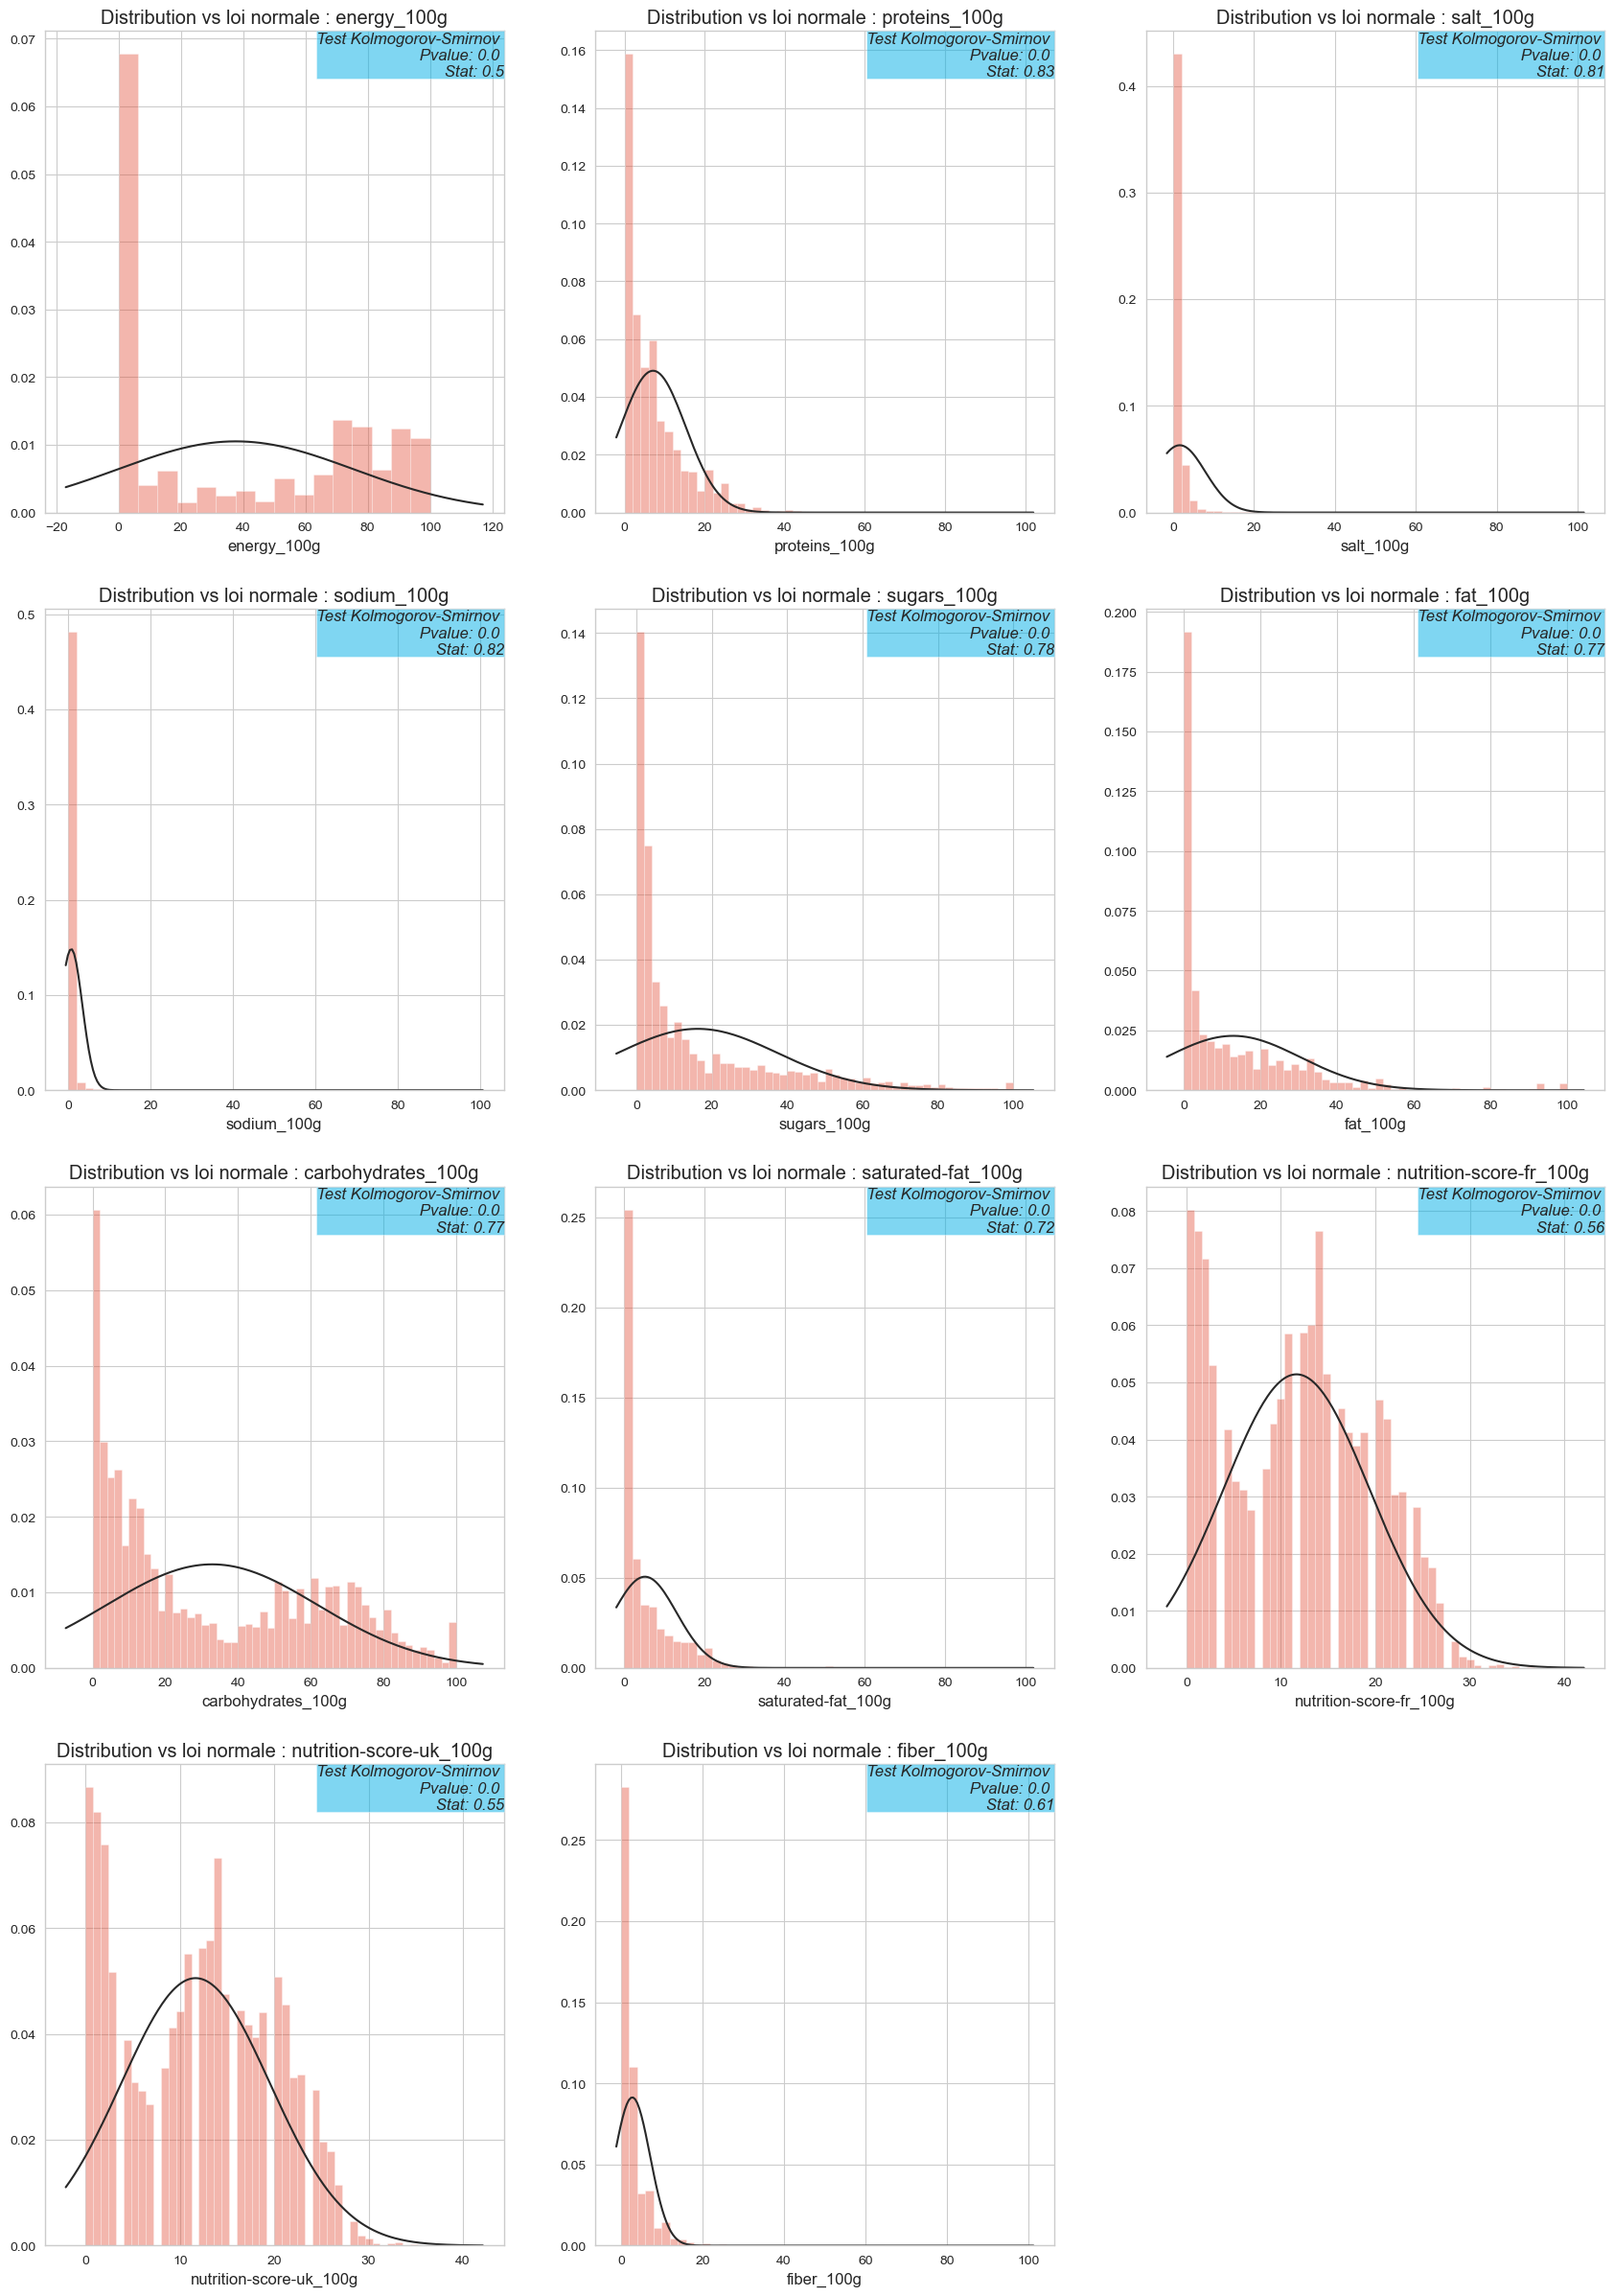

In [45]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(feature_col)):
    fig.add_subplot(4,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = feature_col[i]
    kstest = stats.kstest(data_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(data_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
plt.savefig("Test_normalité.png", tansparent=True)
plt.show()


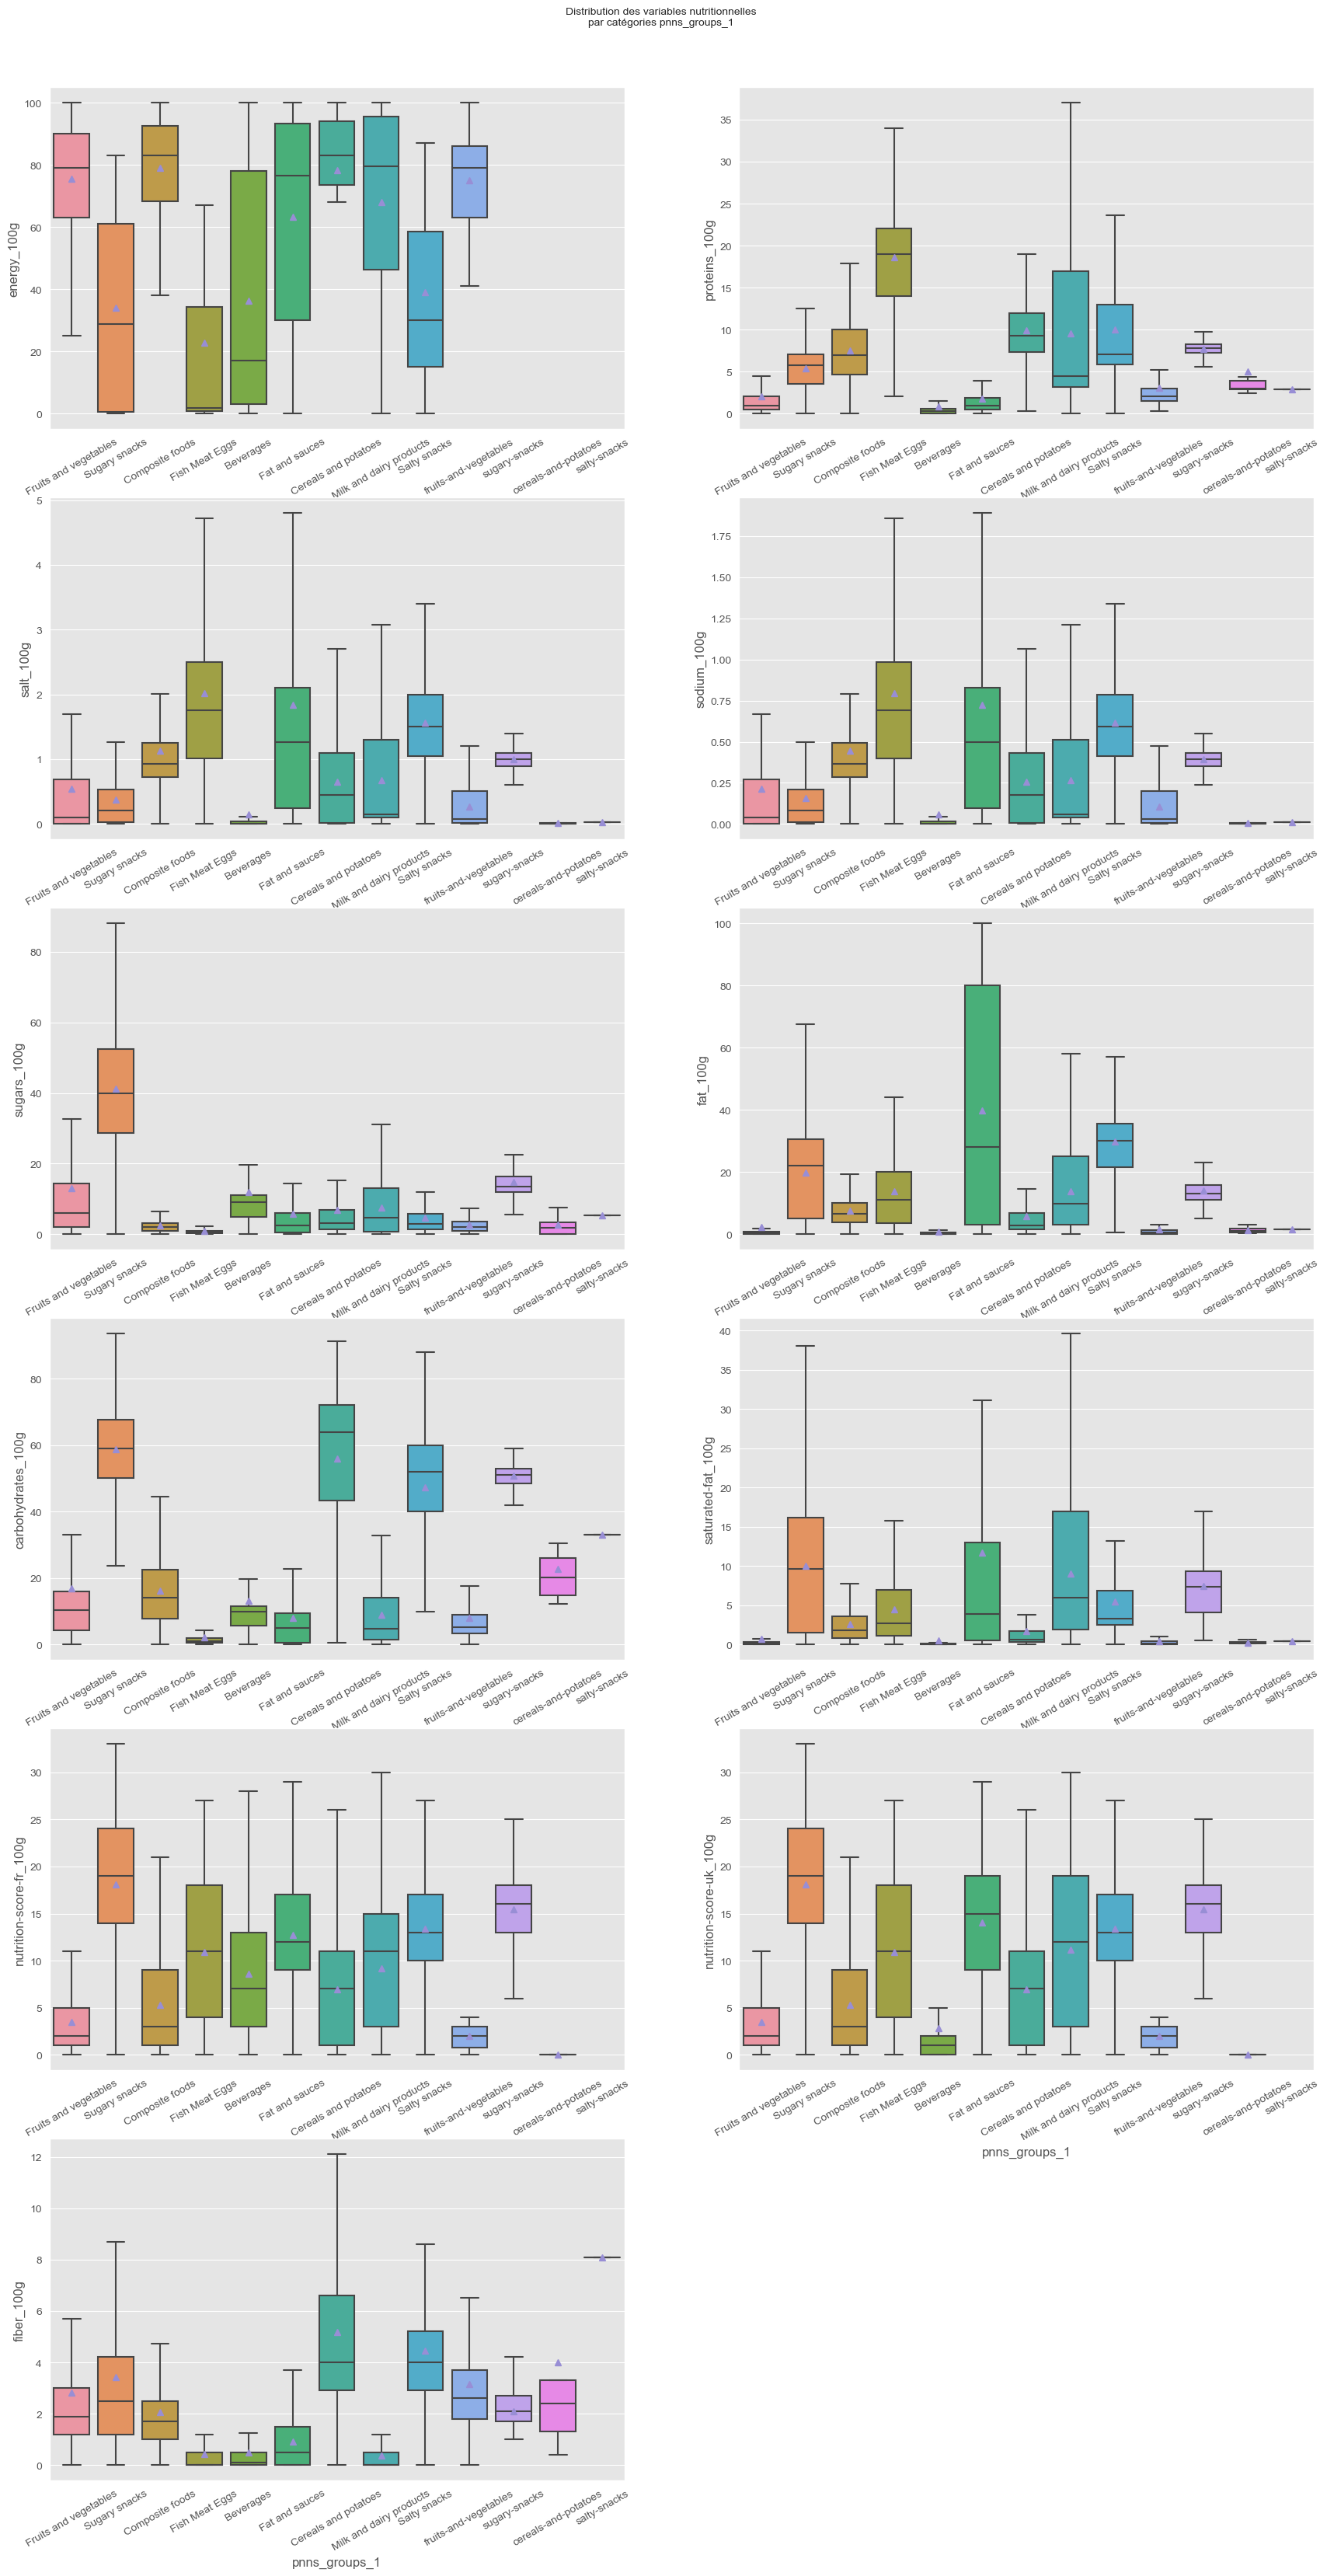

In [69]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,40))

sub = 0
for i in range(len(feature_col)):
    fig.add_subplot(6,2,i+1)
    colonne = feature_col[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=data_cleaned[data_cleaned["pnns_groups_1"]!="unknown"], 
                     showfliers=False,  showmeans=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, "Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center")
plt.savefig("Boîtes_moustaches.png")
plt.show()


In [28]:
# On regarde le pourcentage des valeurs nulles pour les features
(data_cleaned[feature_col].isnull().sum() / data_cleaned.shape[0] ) * 100

energy_100g                94.537745
proteins_100g               0.982494
salt_100g                   2.647275
sodium_100g                 2.604954
sugars_100g                 6.210200
fat_100g                    7.319263
carbohydrates_100g          7.441481
saturated-fat_100g         11.750769
nutrition-score-fr_100g    28.545719
nutrition-score-uk_100g    29.188058
fiber_100g                 22.882931
dtype: float64

In [29]:
data_cleaned[feature_col].head()

,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g
1,NaN,3.57,0.00000,0.000,14.29,28.57,64.29,28.57,14.0,14.0,3.6
2,NaN,17.86,0.63500,0.250,17.86,17.86,60.71,0.00,0.0,0.0,7.1
3,NaN,17.86,1.22428,0.482,3.57,57.14,17.86,5.36,12.0,12.0,7.1
4,NaN,8.57,NaN,NaN,NaN,1.43,77.14,NaN,NaN,NaN,5.7
5,NaN,13.46,NaN,NaN,11.54,18.27,63.46,1.92,NaN,NaN,7.7


**3.** Imputation des valeurs manquantes : 

In [30]:
# KNN pour les autres variables

from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
# knn_features = ['MG_100g','MGS_100g','glucides_100g','sugars_100g']

knn_features = feature_col[:-1]
sample_data = data_cleaned[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_data)

KNNImputer()

In [31]:
# Puis on applique le modèle sur l'ensemble des données

data_imputed = imputer.transform(data_cleaned[knn_features])
df_data_imputed = pd.DataFrame(data_imputed, columns=knn_features)

In [62]:
for col_knn in knn_features:
    data_cleaned[col_knn] = df_data_imputed[col_knn].values

In [63]:
# Remplissage des valeurs manquantes de 'fiber_100g' par la médiane des différents groupes ("pnns_group_2" ...)

for grp in util_col[2:]:
    col = feature_col[-1]
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned.groupby(grp)[col].transform('median'))

In [64]:
data_cleaned.head()

,code,product_name,categories_fr,main_category_fr,pnns_groups_1,pnns_groups_2,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g,glycemic-index_100g
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,27.800,3.57,0.000000,0.000000,14.29,28.57,64.29,28.57,14.0,14.0,3.6,NaN
2,0000000004559,Peanuts,NaN,NaN,NaN,NaN,59.400,17.86,0.635000,0.250000,17.86,17.86,60.71,0.00,0.0,0.0,7.1,NaN
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,13.800,17.86,1.224280,0.482000,3.57,57.14,17.86,5.36,12.0,12.0,7.1,NaN
4,0000000016094,Organic Polenta,NaN,NaN,NaN,NaN,23.692,8.57,2.046556,0.805731,6.19,1.43,77.14,0.12,7.8,7.8,5.7,NaN
5,0000000016100,Breadshop Honey Gone Nuts Granola,NaN,NaN,NaN,NaN,31.600,13.46,1.089296,0.428857,11.54,18.27,63.46,1.92,6.8,6.8,7.7,NaN


In [65]:
# On regarde le pourcentage des valeurs nulles après ce premier remplissage
(data_cleaned[feature_col].isnull().sum() / data_cleaned.shape[0] ) * 100

energy_100g                0.0
proteins_100g              0.0
salt_100g                  0.0
sodium_100g                0.0
sugars_100g                0.0
fat_100g                   0.0
carbohydrates_100g         0.0
saturated-fat_100g         0.0
nutrition-score-fr_100g    0.0
nutrition-score-uk_100g    0.0
fiber_100g                 0.0
dtype: float64

In [66]:
# Remplissage des valeurs qui restent manquantes de 'fiber_100g' par la médiane globale

#for col in feature_col[:]:
 #   data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].median())

In [68]:
# On regarde le pourcentage des valeurs nulles pour les features
#(data_cleaned[feature_col].isnull().sum() / data_cleaned.shape[0] ) * 100

In [69]:
data_cleaned[feature_col].sample(5)

,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g
171559,18.400,6.67,0.00000,0.000000,0.00,0.000,84.44,0.00,2.8,2.8,2.2
169888,75.200,11.27,0.92964,0.366000,1.41,9.860,11.27,4.23,4.0,4.0,1.4
19427,28.692,10.00,0.27432,0.108000,21.67,10.000,71.67,1.67,0.0,0.0,6.7
74344,82.600,5.29,0.89408,0.352000,0.44,4.850,18.94,1.76,1.0,1.0,1.3
316478,62.600,10.30,1.40000,0.551181,2.60,7.954,40.92,0.70,5.0,5.0,0.0


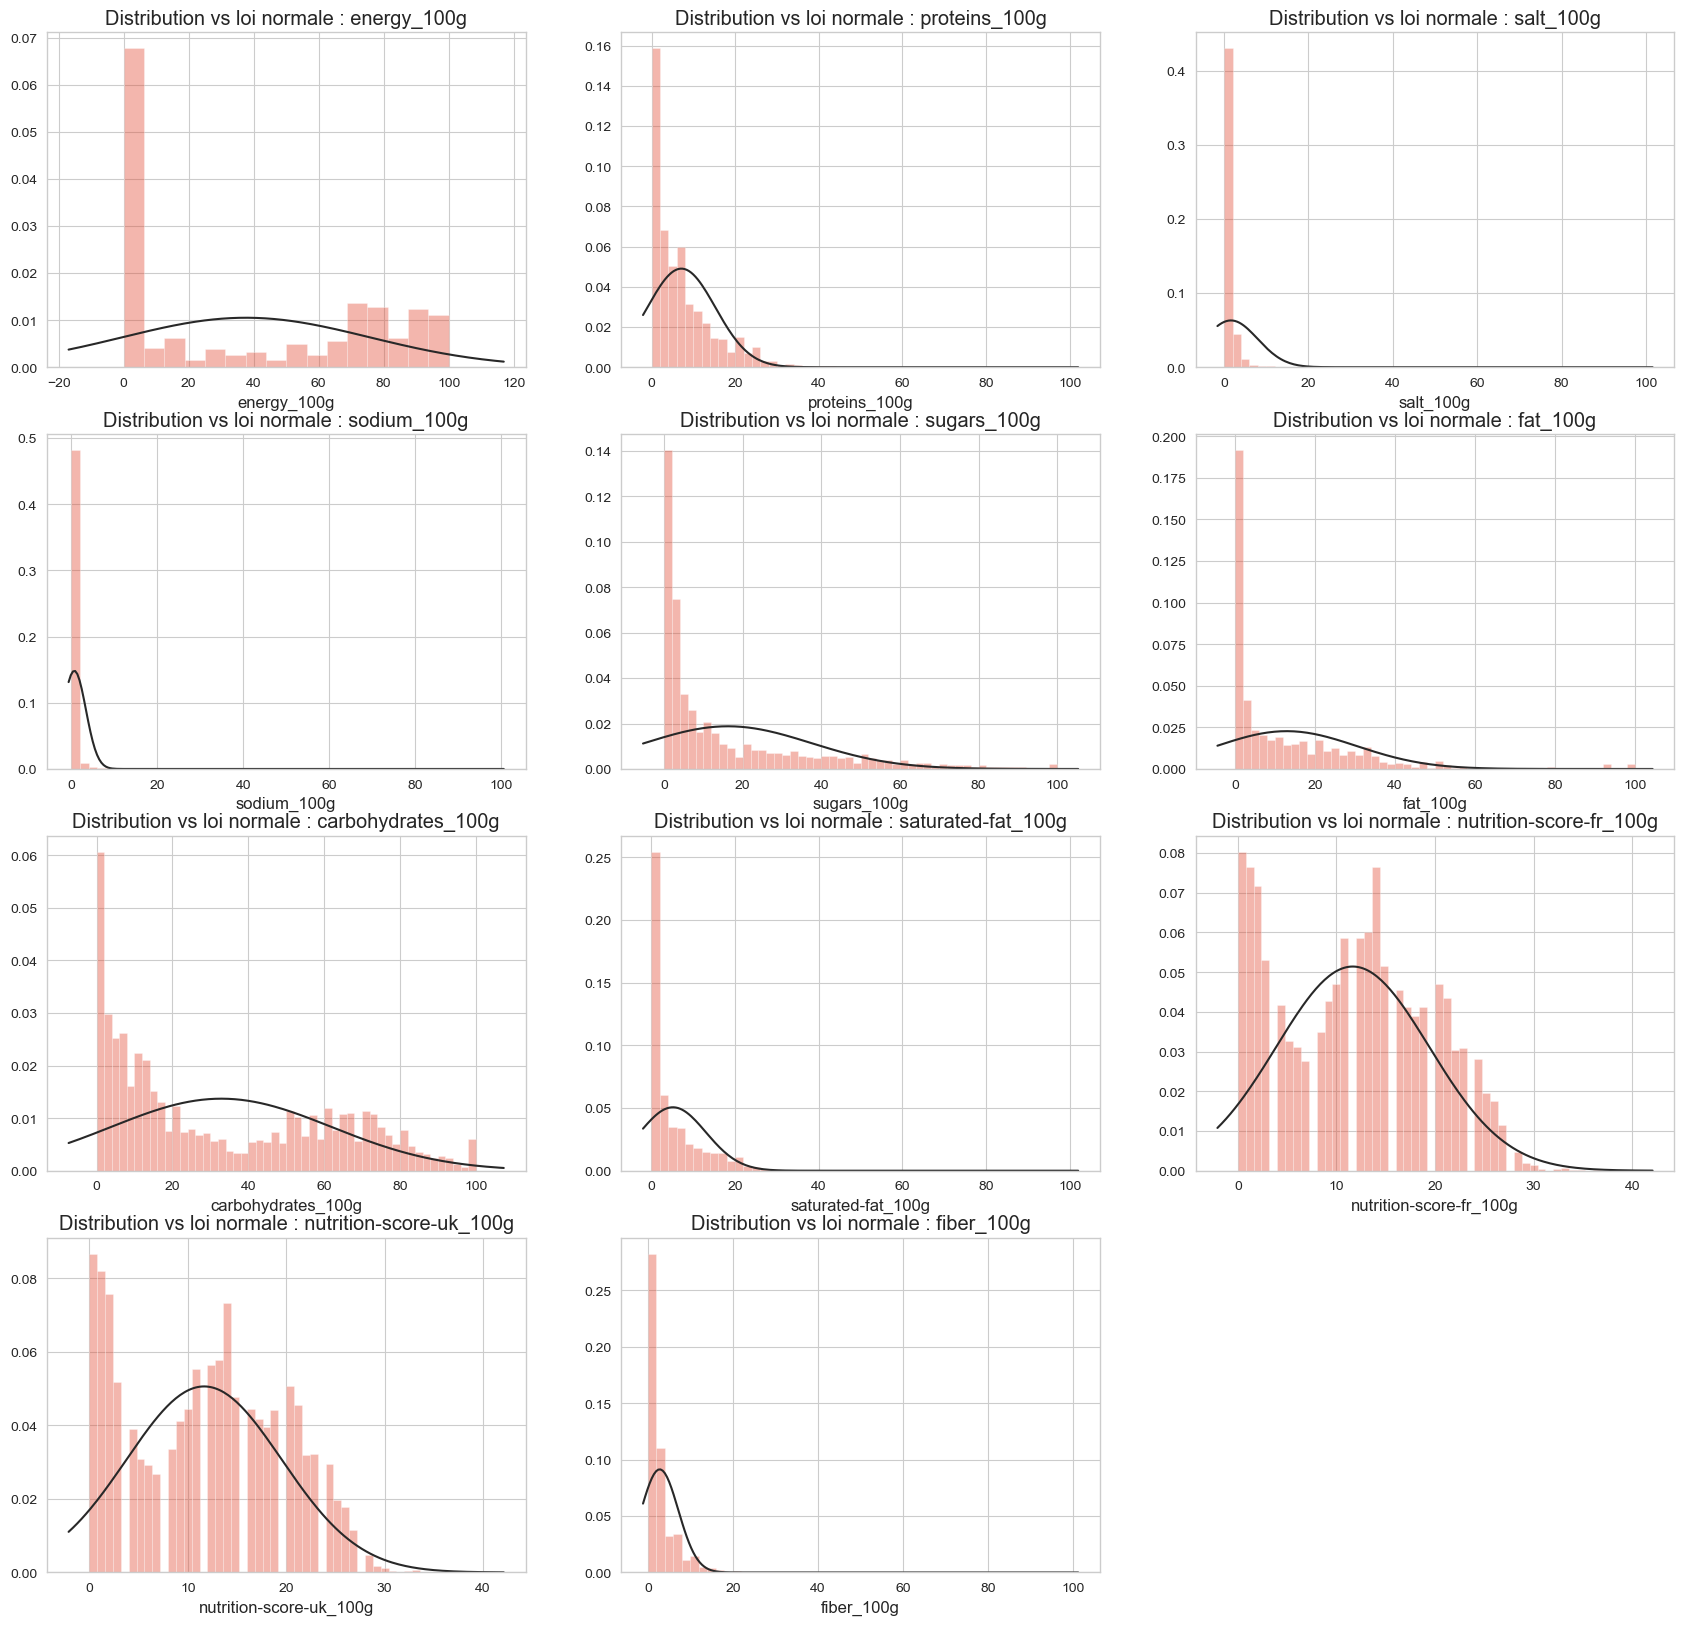

In [46]:
from scipy.stats import norm

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,20))

sub = 0
for i in range(len(feature_col)):
    fig.add_subplot(4,3,i+1)
    colonne = feature_col[i]
    kstest = stats.kstest(data_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(data_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    sub += 1
plt.savefig("test_norm_post_imput.png")
plt.show()


In [71]:
data_cleaned.shape[0]

225201

**4.** Indice Glycémique : 

La variable "indice_glycémique_100g" qui est entièrement vide, est la varaible principale pour notre application. Les tables suivantes ont été importées sur des sites dédiés au diabète. Nous allons compléter une partie de cette colonne. 

In [72]:
# Importer le fichier des indices glycémiques

df = pd.read_csv('IndiceGlycemique2.csv', encoding='latin-1', sep=';')
df.shape

(409, 3)

In [73]:
df.sample(5)

,ALIMENT,Precision,IG
199,Lait damande,NaN,30
117,Farine de blé semi-complète,T80,65
356,Semoule complète,NaN,50
261,Pain azyme,NaN,70
134,Farine de seigle intégrale,T170,40


In [74]:
df = df.assign(Classe_IG = df.IG)
df.Classe_IG = df.Classe_IG.apply(lambda x: 'faible' if x<=39 else ('élevé' if x>60 else 'moyen'))
df.head()

,ALIMENT,Precision,IG,Classe_IG
0,Abricot,sec,30,faible
1,Abricot,frais,57,moyen
2,Abricot,au sirop,64,élevé
3,Agneau,épaule,0,faible
4,Ail,NaN,30,faible


In [75]:
cat = df.iloc[:,0]
pre = df.iloc[:,1]
ig  = df.iloc[:,3]

for i in cat.index:
    print('=====', cat[i], '=====', pre[i], '=====\n')
    if pd.isna(pre[i]):
        txt1 = '^{}[s]?\s'.format(cat[i])
        #print(data.loc[data['product_name'].str.contains(txt1, na=False, regex=True), 'product_name'])
        data_cleaned.loc[data_cleaned['product_name'].str.contains(txt1, na=False, regex=True), 'glycemic-index_100g'] = ig[i]
    else:
        txt1 = '^{}[s]?\s'.format(cat[i])
        txt2 = '{}[s]?\s'.format(pre[i])
        #print(data.loc[data['product_name'].str.contains(txt1, na=False) & data['product_name'].str.contains(txt2, na=False), 'product_name'])
        data_cleaned.loc[data_cleaned['product_name'].str.contains(txt1, na=False) & data_cleaned['product_name'].str.contains(txt2, na=False), 'glycemic-index_100g'] = ig[i]

===== Abricot ===== sec =====

===== Abricot ===== frais =====

===== Abricot ===== au sirop =====

===== Agneau ===== épaule =====

===== Ail ===== nan =====

===== Airelle rouge ===== nan =====

===== Amande ===== nan =====

===== Amarante ===== nan =====

===== Amarante soufflée ===== nan =====

===== Amidons modifiés ===== nan =====

===== Ananas ===== frais =====

===== Ananas ===== boite de conserve =====

===== Arachide ===== cacahuète =====

===== Arrow-root ===== nan =====

===== Artichaut ===== nan =====

===== Asperge ===== nan =====

===== Aubergine ===== nan =====

===== Avocat ===== nan =====

===== Avoine ===== nan =====

===== Bagel ===== nan =====

===== Baie de Goji ===== nan =====

===== Banane ===== pas trop mûre =====

===== Banane ===== bien mûre =====

===== Banane plantain ===== crue =====

===== Banane plantain ===== cuite =====

===== Barre chocolatée ===== nan =====

===== Barre énergétique ===== nan =====

===== Barre muesli aux fruits secs ===== nan =====



===== Maïs doux ===== cuit =====

===== Maizena ===== amidon de maïs =====

===== Maltodextrine ===== nan =====

===== Mandarine ===== nan =====

===== Mangue ===== nan =====

===== Manioc ===== nan =====

===== Marron ===== nan =====

===== Mayonnaise ===== industrielle =====

===== Mélasse ===== nan =====

===== Melon ===== nan =====

===== Miel ===== mélange typique =====

===== Mil ===== nan =====

===== Milk shake framboise ===== nan =====

===== Millet ===== nan =====

===== Moutarde ===== nan =====

===== Moutarde avec sucre ajouté ===== nan =====

===== Muesli ===== naturel =====

===== Muesli sucré ===== nan =====

===== Muffin aux pommes ===== fait maison =====

===== Mûre ===== nan =====

===== Myrtille ===== nan =====

===== Navet ===== cru =====

===== Navet ===== cuit =====

===== Nectarine ===== fraiche =====

===== Noisette ===== nan =====

===== Noix de Grenoble ===== nan =====

===== Noix de cajou ===== salée =====

===== Noix de coco ===== fraiche =====

===== Noix d

In [76]:
data_cleaned.sample(8)

,code,product_name,categories_fr,main_category_fr,pnns_groups_1,pnns_groups_2,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fiber_100g,glycemic-index_100g
40395,0041224704848,White Balsamic,NaN,NaN,NaN,NaN,16.800,0.00,0.00000,0.000000,46.67,0.00,46.67,0.00,12.00,12.00,1.4,NaN
301356,8000920200353,Viennetta cappuccino,"Desserts,Surgelés,Desserts glacés,Glaces et so...",Glaces,Milk and dairy products,Ice cream,0.000,2.80,0.13000,0.051181,22.00,15.00,24.00,14.00,17.00,17.00,0.7,NaN
87568,0074807418399,Shells N' Cheese,NaN,NaN,NaN,NaN,78.600,12.39,2.31648,0.912000,2.65,11.50,39.82,5.31,16.00,16.00,1.8,NaN
38897,0041190039531,"Fruit Singles In Light Syrup, Tropical Fruit",NaN,NaN,NaN,NaN,65.300,0.00,0.02286,0.009000,15.04,0.00,15.93,0.00,2.00,2.00,0.9,NaN
101430,0083322014610,"Greek Nonfat Yogurt, Vanilla Bean",NaN,NaN,NaN,NaN,88.600,8.24,0.08128,0.032000,8.24,2.65,15.29,0.59,0.88,0.88,1.2,NaN
139806,0744473913053,"Coconut Milk Beverage, Pumpkin Spice",NaN,NaN,NaN,NaN,83.700,0.00,0.24384,0.096000,11.67,0.83,12.50,0.83,2.00,2.00,0.8,NaN
21389,0024300033049,"Chewy Granola Bars, Fudge Dipped Chocolate Chip",NaN,NaN,NaN,NaN,37.600,6.25,0.39624,0.156000,34.38,21.88,65.62,14.06,20.00,20.00,3.1,NaN
8263,0011213110899,"Peach, Almond & Multigrain Oatmeal, Peach Almond",NaN,NaN,NaN,NaN,56.292,10.67,0.54102,0.213000,25.33,8.00,70.67,1.33,7.00,7.00,6.7,NaN


In [77]:
# Nombre de lignes remplies par l'indice glycémique
data_cleaned['glycemic-index_100g'].notnull().sum()

6369

In [78]:
data_cleaned['glycemic-index_100g'].sample(5)

149636    NaN
27650     NaN
58271     NaN
157411    NaN
37723     NaN
Name: glycemic-index_100g, dtype: object

In [79]:
data_cleaned.to_csv('data_cleaned.csv')